# Extract point values at Lon, Lat, Dep, Time locations from a curvilinear ocean model grid

imports

In [49]:
import sys
print("python version =",sys.version[:5])

import os
import numpy as np
import xarray as xr
import pandas as pd
import dask as dsk
from dask.diagnostics import ProgressBar
import xesmf as xe

# plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

print("numpy version =", np.__version__)
print("xarray version =", xr.__version__)
print("dask version =", dsk.__version__)
print("pandas version =", pd.__version__)
print("xesmf version =", xe.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/JRA55"
os.chdir(wrkdir)
os.getcwd()

ProgressBar().register()

python version = 3.10.
numpy version = 1.24.4
xarray version = 2023.8.0
dask version = 2023.3.0
pandas version = 2.1.0
xesmf version = 0.7.1
matplotlib version = 3.7.1
cartopy version = 0.22.0
cmocean version = v3.0.3


In [50]:
os.listdir()

['JRA55_pic_1m_ptrc_T_2018-2022.nc',
 'JRA55_co2_1m_diad_T_Y2023.nc',
 'JRA55_13co2_1m_ptrc_T_1958-2022.nc',
 'JRA55_ndep_1m_diad_T_2018-2022.nc',
 'JRA55_hydroOFF_1y_diad_T_1958-2022.nc',
 'JRA55_pic_1y_diad_T_1958-2022.nc',
 'JRA55_pic_1m_diad_T_Y2023.nc',
 'JRA55_ndep_1m_diad_T_1998-2007.nc',
 'JRA55_pic_1m_ptrc_T_1998-2007.nc',
 'JRA55_hydroOFF_1m_icemod_1958-2022.nc',
 'JRA55_pic_1m_icemod_1958-2022.nc',
 'JRA55_ndep_1y_ptrc_T_1958-2022.nc',
 'JRA55_ndep_1y_bioscaler_1850-2022.nc',
 'JRA55_ndep_1d_bioscaler_1958-2022.nc',
 'JRA55_pic_1m_ptrc_T_1968-1977.nc',
 'JRA55_hydroOFF_1m_ptrc_T_1968-1977.nc',
 'JRA55_hydroOFF_1d_bioscaler_1958-2022.nc',
 'JRA55_pic_1m_ptrc_T_1978-1987.nc',
 'JRA55_pic_1m_grid_V_Y2023.nc',
 'JRA55_ndep_1m_ptrc_T_1958-1967.nc',
 'JRA55_hydroOFF_1m_diad_T_1958-1967.nc',
 'JRA55_pic_1m_diad_T_1958-1967.nc',
 'JRA55_ndep_1m_diad_T_1968-1977.nc',
 'JRA55_ndep_1m_diad_T_1978-1987.nc',
 'JRA55_pic_1m_thetao_1958-2022.nc',
 'JRA55_hydroOFF_1y_bioscaler_1850-2022.nc'

load the model data

In [51]:
phy_vars = ['thetao', 'so', 'mldr10_1']
bgc_vars = ['O2', 'DIC', 'DIC_13', 'Alkalini', 'NH4', 'NO3', 'PO4', 'Si', 'Fer', 'NCHL', 'DCHL']
co2_vars = ['DIC', 'DIC_13', 'Alkalini']

### PIC ###
print("Loading PIC experiment data")
fnames = ["JRA55_pic_1m_ptrc_T_1958-1967.nc",
          "JRA55_pic_1m_ptrc_T_1968-1977.nc",
          "JRA55_pic_1m_ptrc_T_1978-1987.nc",
          "JRA55_pic_1m_ptrc_T_1988-1997.nc",
          "JRA55_pic_1m_ptrc_T_1998-2007.nc",
          "JRA55_pic_1m_ptrc_T_2008-2017.nc",
          "JRA55_pic_1m_ptrc_T_2018-2022.nc"]
dat1 = xr.open_dataset(fnames[0])[bgc_vars]
dat2 = xr.open_dataset(fnames[1])[bgc_vars]
dat3 = xr.open_dataset(fnames[2])[bgc_vars]
dat4 = xr.open_dataset(fnames[3])[bgc_vars]
dat5 = xr.open_dataset(fnames[4])[bgc_vars]
dat6 = xr.open_dataset(fnames[5])[bgc_vars]
dat7 = xr.open_dataset(fnames[6])[bgc_vars]
print("  Doing BGC variables")
pic_bgc = xr.concat([dat1,dat2,dat3,dat4,dat5,dat6,dat7], dim="record")
dat1 = xr.open_dataset(fnames[0])['Age']
dat2 = xr.open_dataset(fnames[1])['Age']
dat3 = xr.open_dataset(fnames[2])['Age']
dat4 = xr.open_dataset(fnames[3])['Age']
dat5 = xr.open_dataset(fnames[4])['Age']
dat6 = xr.open_dataset(fnames[5])['Age']
dat7 = xr.open_dataset(fnames[6])['Age']
print("  Doing Age variable")
pic_age = xr.concat([dat1,dat2,dat3,dat4,dat5,dat6,dat7], dim="record")
print("  Doing Physical variables")
pic_phy = xr.open_dataset("JRA55_pic_1m_grid_T_1958-2022.nc")[phy_vars]


### CO2 ###
print("Loading CO2 experiment data")
print("  Doing BGC variables")
co2_bgc = xr.open_dataset("JRA55_co2_1m_ptrc_T_1958-2022.nc")[co2_vars]


### 13CO2 ###
print("Loading 13-CO2 experiment data")
print("  Doing BGC variables")
c13_bgc = xr.open_dataset("JRA55_13co2_1m_ptrc_T_1958-2022.nc")[co2_vars]


### Ndep ###
print("Loading Ndep experiment data")
fnames = ["JRA55_ndep_1m_ptrc_T_1958-1967.nc",
          "JRA55_ndep_1m_ptrc_T_1968-1977.nc",
          "JRA55_ndep_1m_ptrc_T_1978-1987.nc",
          "JRA55_ndep_1m_ptrc_T_1988-1997.nc",
          "JRA55_ndep_1m_ptrc_T_1998-2007.nc",
          "JRA55_ndep_1m_ptrc_T_2008-2017.nc",
          "JRA55_ndep_1m_ptrc_T_2018-2022.nc"]
dat1 = xr.open_dataset(fnames[0])[bgc_vars]
dat2 = xr.open_dataset(fnames[1])[bgc_vars]
dat3 = xr.open_dataset(fnames[2])[bgc_vars]
dat4 = xr.open_dataset(fnames[3])[bgc_vars]
dat5 = xr.open_dataset(fnames[4])[bgc_vars]
dat6 = xr.open_dataset(fnames[5])[bgc_vars]
dat7 = xr.open_dataset(fnames[6])[bgc_vars]
print("  Doing BGC variables")
ndep_bgc = xr.concat([dat1,dat2,dat3,dat4,dat5,dat6,dat7], dim="record")



Loading PIC experiment data
  Doing BGC variables
  Doing Age variable
  Doing Physical variables
Loading CO2 experiment data
  Doing BGC variables
Loading 13-CO2 experiment data
  Doing BGC variables
Loading Ndep experiment data
  Doing BGC variables


## alter the data arrays such that we fold the 2 time dimensions into 1

### First, rename some dimensions for clarity and reassign the month coordinate

In [52]:
pic_phy = pic_phy.rename({"time_counter": "month"})
pic_phy = pic_phy.rename({"record": "year"})
pic_phy = pic_phy.assign_coords(month=np.arange(1,13,1))

pic_age = pic_age.rename({"time_counter": "month"})
pic_age = pic_age.rename({"record": "year"})
pic_age = pic_age.assign_coords(month=np.arange(1,13,1))

pic_bgc = pic_bgc.rename({"time_counter": "month"})
pic_bgc = pic_bgc.rename({"record": "year"})
pic_bgc = pic_bgc.assign_coords(month=np.arange(1,13,1))

co2_bgc = co2_bgc.rename({"time_counter": "month"})
co2_bgc = co2_bgc.rename({"record": "year"})
co2_bgc = co2_bgc.assign_coords(month=np.arange(1,13,1))

c13_bgc = c13_bgc.rename({"time_counter": "month"})
c13_bgc = c13_bgc.rename({"record": "year"})
c13_bgc = c13_bgc.assign_coords(month=np.arange(1,13,1))

ndep_bgc = ndep_bgc.rename({"time_counter": "month"})
ndep_bgc = ndep_bgc.rename({"record": "year"})
ndep_bgc = ndep_bgc.assign_coords(month=np.arange(1,13,1))


### create new time variable that will become added to the xarray

In [54]:
from datetime import datetime, timedelta
start_date = datetime(1958, 1, 1)
end_date = datetime(2022, 12, 31)
time = pd.date_range(start=start_date, end=end_date, freq="MS") + pd.DateOffset(days=14)
time

DatetimeIndex(['1958-01-15', '1958-02-15', '1958-03-15', '1958-04-15',
               '1958-05-15', '1958-06-15', '1958-07-15', '1958-08-15',
               '1958-09-15', '1958-10-15',
               ...
               '2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15',
               '2022-07-15', '2022-08-15', '2022-09-15', '2022-10-15',
               '2022-11-15', '2022-12-15'],
              dtype='datetime64[ns]', length=780, freq=None)

### Fold year and month into each other to make a single time dimension

In [56]:
pic_phy = pic_phy.assign_coords(stacked_time=time)
pic_bgc = pic_bgc.assign_coords(stacked_time=time)
c13_bgc = pic_bgc.assign_coords(stacked_time=time)
co2_bgc = pic_bgc.assign_coords(stacked_time=time)
ndep_bgc = pic_bgc.assign_coords(stacked_time=time)

# stack the year and month dimensions into the new dimension
#   the new coordinate should have dimensions the same size as our new time coordinate
pic_phy = pic_phy.stack(stacked_time=("year", "month"))
pic_bgc = pic_bgc.stack(stacked_time=("year", "month"))
co2_bgc = co2_bgc.stack(stacked_time=("year", "month"))
c13_bgc = c13_bgc.stack(stacked_time=("year", "month"))
ndep_bgc = ndep_bgc.stack(stacked_time=("year", "month"))

# we remove the "stacked_time" coordinate and everything associated with it (year + month)
pic_phy = pic_phy.drop_vars(["stacked_time", "year", "month"])
pic_bgc = pic_bgc.drop_vars(["stacked_time", "year", "month"])
co2_bgc = co2_bgc.drop_vars(["stacked_time", "year", "month"])
c13_bgc = c13_bgc.drop_vars(["stacked_time", "year", "month"])
ndep_bgc = ndep_bgc.drop_vars(["stacked_time", "year", "month"])

# we make the remaining time coordinate, with now the dimensions we want, have the values we want
pic_phy = pic_phy.assign_coords(time_centered=time)
pic_bgc = pic_bgc.assign_coords(time_centered=time)
co2_bgc = co2_bgc.assign_coords(time_centered=time)
c13_bgc = c13_bgc.assign_coords(time_centered=time)
ndep_bgc = ndep_bgc.assign_coords(time_centered=time)

# for some reason, do different recipe for Age dataarray
pic_age = pic_age.stack(stacked_time=("year", "month"))
pic_age = pic_age.drop_vars(["stacked_time", "year", "month"])
pic_age = pic_age.rename({"stacked_time":"time"})
pic_age = pic_age.assign_coords(time=time)
pic_age = pic_age.drop_vars(["time_centered"])


### get the variables we want

In [81]:
pic_t = pic_phy.thetao
pic_s = pic_phy.so
pic_mld = pic_phy.mldr10_1

pic_dic = pic_bgc.DIC
pic_dic13 = pic_bgc.DIC_13
pic_alk = pic_bgc.Alkalini
pic_oxy = pic_bgc.O2
pic_nh4 = pic_bgc.NH4
pic_no3 = pic_bgc.NO3
pic_po4 = pic_bgc.PO4
pic_sil = pic_bgc.Si
pic_dfe = pic_bgc.Fer
pic_nch = pic_bgc.NCHL
pic_dch = pic_bgc.DCHL

co2_dic = co2_bgc.DIC
co2_dic13 = co2_bgc.DIC_13
co2_alk = co2_bgc.Alkalini

c13_dic = c13_bgc.DIC
c13_dic13 = c13_bgc.DIC_13

ndep_dic = ndep_bgc.DIC
ndep_dic13 = ndep_bgc.DIC_13
ndep_alk = ndep_bgc.Alkalini
ndep_oxy = ndep_bgc.O2
ndep_nh4 = ndep_bgc.NH4
ndep_no3 = ndep_bgc.NO3
ndep_po4 = ndep_bgc.PO4
ndep_sil = ndep_bgc.Si
ndep_dfe = ndep_bgc.Fer
ndep_nch = ndep_bgc.NCHL
ndep_dch = ndep_bgc.DCHL

pic_t = pic_t.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_s = pic_s.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_mld = pic_mld.rename({"stacked_time":"time"}).assign_coords(time=time)

pic_dic = pic_dic.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_dic13 = pic_dic13.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_alk = pic_alk.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_oxy = pic_oxy.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_nh4 = pic_nh4.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_no3 = pic_no3.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_po4 = pic_po4.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_sil = pic_sil.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_dfe = pic_dfe.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_nch = pic_nch.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_dch = pic_dch.rename({"stacked_time":"time"}).assign_coords(time=time)

co2_dic = co2_dic.rename({"stacked_time":"time"}).assign_coords(time=time)
co2_dic13 = co2_dic13.rename({"stacked_time":"time"}).assign_coords(time=time)
co2_alk = co2_alk.rename({"stacked_time":"time"}).assign_coords(time=time)


c13_dic = c13_dic.rename({"stacked_time":"time"}).assign_coords(time=time)
c13_dic13 = c13_dic13.rename({"stacked_time":"time"}).assign_coords(time=time)


ndep_dic = ndep_dic.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_dic13 = ndep_dic13.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_alk = ndep_alk.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_oxy = ndep_oxy.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_nh4 = ndep_nh4.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_no3 = ndep_no3.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_po4 = ndep_po4.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_sil = ndep_sil.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_dfe = ndep_dfe.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_nch = ndep_nch.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_dch = ndep_dch.rename({"stacked_time":"time"}).assign_coords(time=time)


### apply chunking

In [87]:
ProgressBar().register()
chunky = {'time':20, 'deptht':31, 'y':149, 'x':182}
chunkymld = {'time':20, 'y':149, 'x':182}

pic_t = pic_t.chunk(chunks=chunky)
pic_s = pic_s.chunk(chunks=chunky)
pic_mld = pic_mld.chunk(chunks=chunkymld)
pic_age = pic_age.chunk(chunks=chunky)

pic_dic = pic_dic.chunk(chunks=chunky)
pic_dic13 = pic_dic13.chunk(chunks=chunky)
pic_alk = pic_alk.chunk(chunks=chunky)
pic_oxy = pic_oxy.chunk(chunks=chunky)
pic_nh4 = pic_nh4.chunk(chunks=chunky)
pic_no3 = pic_no3.chunk(chunks=chunky)
pic_po4 = pic_po4.chunk(chunks=chunky)
pic_sil = pic_sil.chunk(chunks=chunky)
pic_dfe = pic_dfe.chunk(chunks=chunky)
pic_nch = pic_nch.chunk(chunks=chunky)
pic_dch = pic_dch.chunk(chunks=chunky)

co2_dic = co2_dic.chunk(chunks=chunky)
co2_dic13 = co2_dic13.chunk(chunks=chunky)
co2_alk = co2_alk.chunk(chunks=chunky)

c13_dic = c13_dic.chunk(chunks=chunky)
c13_dic13 = c13_dic13.chunk(chunks=chunky)

ndep_dic = ndep_dic.chunk(chunks=chunky)
ndep_dic13 = ndep_dic13.chunk(chunks=chunky)
ndep_alk = ndep_alk.chunk(chunks=chunky)
ndep_oxy = ndep_oxy.chunk(chunks=chunky)
ndep_nh4 = ndep_nh4.chunk(chunks=chunky)
ndep_no3 = ndep_no3.chunk(chunks=chunky)
ndep_po4 = ndep_po4.chunk(chunks=chunky)
ndep_sil = ndep_sil.chunk(chunks=chunky)
ndep_dfe = ndep_dfe.chunk(chunks=chunky)
ndep_nch = ndep_nch.chunk(chunks=chunky)
ndep_dch = ndep_dch.chunk(chunks=chunky)


In [89]:
pic_t


<xarray.DataArray 'thetao' (deptht: 31, y: 149, x: 182, time: 780)>
dask.array<xarray-<this-array>, shape=(31, 149, 182, 780), dtype=float32, chunksize=(31, 149, 182, 1), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float32 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
    nav_lat  (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
  * time     (time) datetime64[ns] 1958-01-15 1958-02-15 ... 2022-12-15
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)
    cell_measures:       area: area

## Regrid the dataarrays!

In [90]:
### create the rectilinear grid
ds_out = xe.util.grid_global(0.25,0.25)
ds_out


<xarray.Dataset>
Dimensions:  (y: 720, x: 1440, y_b: 721, x_b: 1441)
Coordinates:
    lon      (y, x) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    lat      (y, x) float64 -89.88 -89.88 -89.88 -89.88 ... 89.88 89.88 89.88
    lon_b    (y_b, x_b) float64 -180.0 -179.8 -179.5 ... 179.5 179.8 180.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [94]:
# regrid the curvilinear --> rectilinear
regridder = xe.Regridder(pic_phy, ds_out, 'bilinear', ignore_degenerate=True)
print("Regridding PIC physical variables")
pic_t_reg = regridder(pic_t)
pic_s_reg = regridder(pic_s)
pic_mld_reg = regridder(pic_mld)
pic_age_reg = regridder(pic_age)
print("Regridding PIC BGC variables")
pic_dic_reg = regridder(pic_dic)
pic_dic13_reg = regridder(pic_dic13)
pic_alk_reg = regridder(pic_alk)
pic_oxy_reg = regridder(pic_oxy)
pic_nh4_reg = regridder(pic_nh4)
pic_no3_reg = regridder(pic_no3)
pic_po4_reg = regridder(pic_po4)
pic_dfe_reg = regridder(pic_dfe)
pic_sil_reg = regridder(pic_sil)
pic_nch_reg = regridder(pic_nch)
pic_dch_reg = regridder(pic_dch)
print("Regridding CO2 BGC variables")
co2_dic_reg = regridder(co2_dic)
co2_dic13_reg = regridder(co2_dic13)
co2_alk_reg = regridder(co2_alk)
print("Regridding 13CO2 BGC variables")
c13_dic_reg = regridder(c13_dic)
c13_dic13_reg = regridder(c13_dic13)
print("Regridding Ndep BGC variables")
ndep_dic_reg = regridder(ndep_dic)
ndep_dic13_reg = regridder(ndep_dic13)
ndep_alk_reg = regridder(ndep_alk)
ndep_oxy_reg = regridder(ndep_oxy)
ndep_nh4_reg = regridder(ndep_nh4)
ndep_no3_reg = regridder(ndep_no3)
ndep_po4_reg = regridder(ndep_po4)
ndep_dfe_reg = regridder(ndep_dfe)
ndep_sil_reg = regridder(ndep_sil)
ndep_nch_reg = regridder(ndep_nch)
ndep_dch_reg = regridder(ndep_dch)



Regridding PIC physical variables
Regridding PIC BGC variables
Regridding CO2 BGC variables
Regridding 13CO2 BGC variables
Regridding Ndep BGC variables


[########################################] | 100% Completed | 101.38 ms
[########################################] | 100% Completed | 101.00 ms
[########################################] | 100% Completed | 101.13 ms
[########################################] | 100% Completed | 101.08 ms
[########################################] | 100% Completed | 101.45 ms
[########################################] | 100% Completed | 101.16 ms
[########################################] | 100% Completed | 200.85 ms
[########################################] | 100% Completed | 100.73 ms
[########################################] | 100% Completed | 200.96 ms
[########################################] | 100% Completed | 201.58 ms
[########################################] | 100% Completed | 300.74 ms
[########################################] | 100% Completed | 401.21 ms
[########################################] | 100% Completed | 401.31 ms
[########################################] | 100% Completed | 50

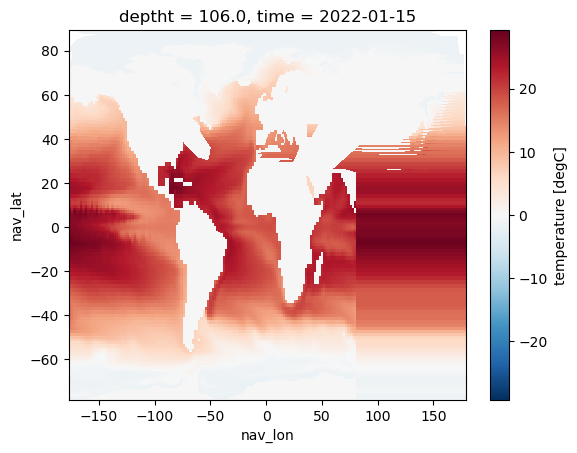

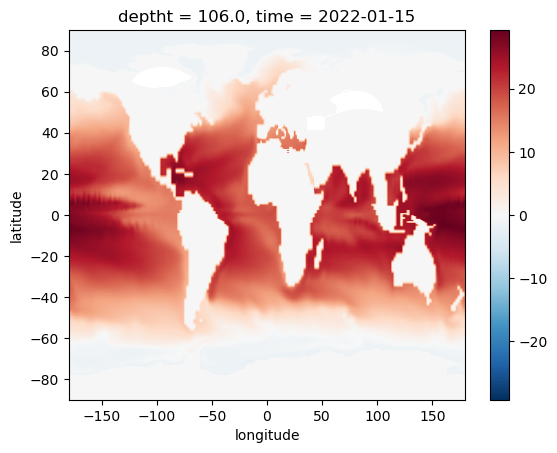

In [92]:
### did the regridding work?
plt.figure()
ax = plt.axes()
pic_t.isel(time=768,deptht=10).plot.pcolormesh(ax=ax, x="nav_lon", y="nav_lat")
plt.figure()
ax = plt.axes()
pic_t_reg.isel(time=768,deptht=10).plot.pcolormesh(ax=ax, x="lon", y="lat")

### Load the observational datafram

In [97]:

oiso_surf = pd.read_excel("/home/pbuchanan/for_Coraline/OISO_SURATLANT_C13_datasets_20230712.xlsx", sheet_name="OISO_surf")
oiso_stn = pd.read_excel("/home/pbuchanan/for_Coraline/OISO_SURATLANT_C13_datasets_20230712.xlsx", sheet_name="OISO_stn")
naspg_surf = pd.read_excel("/home/pbuchanan/for_Coraline/OISO_SURATLANT_C13_datasets_20230712.xlsx", sheet_name="NASPG_surf")

oiso_surf


,Cruise,Year,Month,Day,Hour,Minute,Latitude,Longitude,Depth,d13C_DIC,QF_13C,SST,QF_SST,SSS,QF_SSS
0,oiso2,1998,8,28,16,10,-49.217000,70.700000,5,1.150000,2,2.67,2.0,33.648,2
1,oiso2,1998,8,28,20,0,-48.317000,71.100000,5,1.100000,2,2.18,2.0,33.848,2
2,oiso2,1998,8,29,5,45,-46.567000,72.033000,5,1.270000,2,4.82,2.0,33.748,2
3,oiso2,1998,8,29,10,0,-45.717000,72.683000,5,1.270000,2,4.62,3.0,33.757,3
4,oiso2,1998,8,29,12,0,-45.267000,73.033000,5,1.510000,2,4.39,2.0,33.748,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,oiso32,2022,2,28,6,38,-31.276667,67.950000,5,0.445988,2,23.68,2.0,35.872,2
1069,oiso32,2022,2,28,14,58,-30.000000,66.418333,5,0.395174,2,24.33,2.0,35.853,2
1070,oiso32,2022,2,28,20,50,-32.441667,69.491667,5,0.564956,2,22.47,2.0,35.935,2
1071,oiso32,2022,2,28,23,3,-29.286667,65.211667,5,0.584908,2,24.59,2.0,35.845,2


### extract the data

In [100]:

### now that we are on a regular grid, we can replace the dimensions x and y with lon and lat
lon = pic_t_reg.coords['lon'].values[0]
lat = pic_t_reg.coords['lat'].values[:,0]

pic_t_reg = pic_t_reg.assign_coords(x=lon, y=lat)
pic_s_reg = pic_s_reg.assign_coords(x=lon, y=lat)
pic_mld_reg = pic_mld_reg.assign_coords(x=lon, y=lat)
pic_age_reg = pic_age_reg.assign_coords(x=lon, y=lat)
pic_dic_reg = pic_dic_reg.assign_coords(x=lon, y=lat)
pic_dic13_reg = pic_dic13_reg.assign_coords(x=lon, y=lat)
pic_alk_reg = pic_alk_reg.assign_coords(x=lon, y=lat)
pic_oxy_reg = pic_oxy_reg.assign_coords(x=lon, y=lat)
pic_nh4_reg = pic_nh4_reg.assign_coords(x=lon, y=lat)
pic_no3_reg = pic_no3_reg.assign_coords(x=lon, y=lat)
pic_po4_reg = pic_po4_reg.assign_coords(x=lon, y=lat)
pic_sil_reg = pic_sil_reg.assign_coords(x=lon, y=lat)
pic_dfe_reg = pic_dfe_reg.assign_coords(x=lon, y=lat)
pic_nch_reg = pic_nch_reg.assign_coords(x=lon, y=lat)
pic_dch_reg = pic_dch_reg.assign_coords(x=lon, y=lat)
co2_dic_reg = co2_dic_reg.assign_coords(x=lon, y=lat)
co2_dic13_reg = co2_dic13_reg.assign_coords(x=lon, y=lat)
co2_alk_reg = co2_alk_reg.assign_coords(x=lon, y=lat)
c13_dic_reg = c13_dic_reg.assign_coords(x=lon, y=lat)
c13_dic13_reg = c13_dic13_reg.assign_coords(x=lon, y=lat)
ndep_dic_reg = ndep_dic_reg.assign_coords(x=lon, y=lat)
ndep_dic13_reg = ndep_dic13_reg.assign_coords(x=lon, y=lat)
ndep_alk_reg = ndep_alk_reg.assign_coords(x=lon, y=lat)
ndep_oxy_reg = ndep_oxy_reg.assign_coords(x=lon, y=lat)
ndep_nh4_reg = ndep_nh4_reg.assign_coords(x=lon, y=lat)
ndep_no3_reg = ndep_no3_reg.assign_coords(x=lon, y=lat)
ndep_po4_reg = ndep_po4_reg.assign_coords(x=lon, y=lat)
ndep_sil_reg = ndep_sil_reg.assign_coords(x=lon, y=lat)
ndep_dfe_reg = ndep_dfe_reg.assign_coords(x=lon, y=lat)
ndep_nch_reg = ndep_nch_reg.assign_coords(x=lon, y=lat)
ndep_dch_reg = ndep_dch_reg.assign_coords(x=lon, y=lat)


#### extract for OISO surface data

In [ ]:
oiso_surf


In [ ]:
oiso_surf['mod_PIC_T'] = np.nan
oiso_surf['mod_PIC_S'] = np.nan
oiso_surf['mod_PIC_MLD'] = np.nan
oiso_surf['mod_PIC_Age'] = np.nan
oiso_surf['mod_PIC_DIC'] = np.nan
oiso_surf['mod_PIC_DIC13'] = np.nan
oiso_surf['mod_PIC_Alk'] = np.nan
oiso_surf['mod_PIC_Oxy'] = np.nan
oiso_surf['mod_PIC_NH4'] = np.nan
oiso_surf['mod_PIC_NO3'] = np.nan
oiso_surf['mod_PIC_PO4'] = np.nan
oiso_surf['mod_PIC_Sil'] = np.nan
oiso_surf['mod_PIC_dFe'] = np.nan
oiso_surf['mod_PIC_nChl'] = np.nan
oiso_surf['mod_PIC_dChl'] = np.nan
oiso_surf['mod_CO2_DIC'] = np.nan
oiso_surf['mod_CO2_DIC13'] = np.nan
oiso_surf['mod_CO2_Alk'] = np.nan
oiso_surf['mod_13CO2_DIC'] = np.nan
oiso_surf['mod_13CO2_DIC13'] = np.nan
oiso_surf['mod_NDEP_DIC'] = np.nan
oiso_surf['mod_NDEP_DIC13'] = np.nan
oiso_surf['mod_NDEP_Alk'] = np.nan
oiso_surf['mod_NDEP_Oxy'] = np.nan
oiso_surf['mod_NDEP_NH4'] = np.nan
oiso_surf['mod_NDEP_NO3'] = np.nan
oiso_surf['mod_NDEP_PO4'] = np.nan
oiso_surf['mod_NDEP_Sil'] = np.nan
oiso_surf['mod_NDEP_dFe'] = np.nan
oiso_surf['mod_NDEP_nChl'] = np.nan
oiso_surf['mod_NDEP_dChl'] = np.nan

for ii in np.arange(len(oiso_surf)):
    xx = oiso_surf["Longitude"][ii]
    yy = oiso_surf["Latitude"][ii]
    zz = oiso_surf["Depth"][ii]
    yr = oiso_surf["Year"][ii]
    mm = oiso_surf["Month"][ii]
    dd = oiso_surf["Day"][ii]
    hh = oiso_surf["Hour"][ii]
    date = pd.to_datetime(f'{yr}-{mm:02d}-{dd:02d} {hh:02d}:00:00')
    oiso_surf.loc[ii,"mod_PIC_T"] = pic_t_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_S"] = pic_s_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_MLD"] = pic_mld_reg.sel(x=xx, y=yy, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_Age"] = pic_age_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_DIC"] = pic_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_DIC13"] = pic_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_Alk"] = pic_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_Oxy"] = pic_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_NH4"] = pic_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_NO3"] = pic_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_PO4"] = pic_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_Sil"] = pic_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_dFe"] = pic_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_nChl"] = pic_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_dChl"] = pic_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_CO2_DIC"] = co2_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_CO2_DIC13"] = co2_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_CO2_Alk"] = co2_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_13CO2_DIC"] = c13_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_13CO2_DIC13"] = c13_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_DIC"] = ndep_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_DIC13"] = ndep_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_Alk"] = ndep_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_Oxy"] = ndep_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_NH4"] = ndep_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_NO3"] = ndep_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_PO4"] = ndep_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_Sil"] = ndep_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_dFe"] = ndep_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_nChl"] = ndep_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_dChl"] = ndep_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    


[########################################] | 100% Completed | 502.68 ms
[########################################] | 100% Completed | 503.35 ms
[########################################] | 100% Completed | 602.70 ms
[########################################] | 100% Completed | 603.22 ms
[########################################] | 100% Completed | 702.67 ms
[########################################] | 100% Completed | 802.63 ms
[########################################] | 100% Completed | 902.65 ms
[########################################] | 100% Completed | 502.35 ms
[########################################] | 100% Completed | 602.79 ms
[########################################] | 100% Completed | 703.03 ms
[########################################] | 100% Completed | 703.12 ms
[########################################] | 100% Completed | 803.09 ms
[########################################] | 100% Completed | 803.48 ms
[########################################] | 100% Completed | 90

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 502.90 ms
[########################################] | 100% Completed | 503.60 ms
[########################################] | 100% Completed | 603.14 ms
[########################################] | 100% Completed | 603.72 ms
[########################################] | 100% Completed | 702.89 ms
[########################################] | 100% Completed | 702.65 ms
[########################################] | 100% Completed | 703.02 ms
[########################################] | 100% Completed | 502.34 ms
[########################################] | 100% Completed | 502.88 ms
[########################################] | 100% Completed | 602.33 ms
[########################################] | 100% Completed | 602.97 ms
[########################################] | 100% Completed | 603.46 ms
[########################################] | 100% Completed | 703.07 ms
[########################################] | 100% Completed | 80

#### Extract data fro OISO stn

In [ ]:
oiso_stn['mod_PIC_T'] = np.nan
oiso_stn['mod_PIC_S'] = np.nan
oiso_stn['mod_PIC_MLD'] = np.nan
oiso_stn['mod_PIC_Age'] = np.nan
oiso_stn['mod_PIC_DIC'] = np.nan
oiso_stn['mod_PIC_DIC13'] = np.nan
oiso_stn['mod_PIC_Alk'] = np.nan
oiso_stn['mod_PIC_Oxy'] = np.nan
oiso_stn['mod_PIC_NH4'] = np.nan
oiso_stn['mod_PIC_NO3'] = np.nan
oiso_stn['mod_PIC_PO4'] = np.nan
oiso_stn['mod_PIC_Sil'] = np.nan
oiso_stn['mod_PIC_dFe'] = np.nan
oiso_stn['mod_PIC_nChl'] = np.nan
oiso_stn['mod_PIC_dChl'] = np.nan
oiso_stn['mod_CO2_DIC'] = np.nan
oiso_stn['mod_CO2_DIC13'] = np.nan
oiso_stn['mod_CO2_Alk'] = np.nan
oiso_stn['mod_13CO2_DIC'] = np.nan
oiso_stn['mod_13CO2_DIC13'] = np.nan
oiso_stn['mod_NDEP_DIC'] = np.nan
oiso_stn['mod_NDEP_DIC13'] = np.nan
oiso_stn['mod_NDEP_Alk'] = np.nan
oiso_stn['mod_NDEP_Oxy'] = np.nan
oiso_stn['mod_NDEP_NH4'] = np.nan
oiso_stn['mod_NDEP_NO3'] = np.nan
oiso_stn['mod_NDEP_PO4'] = np.nan
oiso_stn['mod_NDEP_Sil'] = np.nan
oiso_stn['mod_NDEP_dFe'] = np.nan
oiso_stn['mod_NDEP_nChl'] = np.nan
oiso_stn['mod_NDEP_dChl'] = np.nan

for ii in np.arange(len(oiso_surf)):
    xx = oiso_stn["Longitude"][ii]
    yy = oiso_stn["Latitude"][ii]
    zz = oiso_stn["Depth"][ii]
    yr = oiso_stn["Year"][ii]
    mm = oiso_stn["Month"][ii]
    dd = oiso_stn["Day"][ii]
    hh = oiso_stn["Hour"][ii]
    date = pd.to_datetime(f'{yr}-{mm:02d}-{dd:02d} {hh:02d}:00:00')
    oiso_stn.loc[ii,"mod_PIC_T"] = pic_t_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_S"] = pic_s_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_MLD"] = pic_mld_reg.sel(x=xx, y=yy, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_Age"] = pic_age_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_DIC"] = pic_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_DIC13"] = pic_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_Alk"] = pic_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_Oxy"] = pic_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_NH4"] = pic_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_NO3"] = pic_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_PO4"] = pic_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_Sil"] = pic_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_dFe"] = pic_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_nChl"] = pic_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_dChl"] = pic_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_CO2_DIC"] = co2_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_CO2_DIC13"] = co2_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_CO2_Alk"] = co2_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_13CO2_DIC"] = c13_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_13CO2_DIC13"] = c13_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_DIC"] = ndep_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_DIC13"] = ndep_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_Alk"] = ndep_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_Oxy"] = ndep_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_NH4"] = ndep_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_NO3"] = ndep_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_PO4"] = ndep_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_Sil"] = ndep_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_dFe"] = ndep_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_nChl"] = ndep_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_dChl"] = ndep_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values


#### Extract model data for the NASPG dataset

In [ ]:
naspg_surf['mod_PIC_T'] = np.nan
naspg_surf['mod_PIC_S'] = np.nan
naspg_surf['mod_PIC_MLD'] = np.nan
naspg_surf['mod_PIC_Age'] = np.nan
naspg_surf['mod_PIC_DIC'] = np.nan
naspg_surf['mod_PIC_DIC13'] = np.nan
naspg_surf['mod_PIC_Alk'] = np.nan
naspg_surf['mod_PIC_Oxy'] = np.nan
naspg_surf['mod_PIC_NH4'] = np.nan
naspg_surf['mod_PIC_NO3'] = np.nan
naspg_surf['mod_PIC_PO4'] = np.nan
naspg_surf['mod_PIC_Sil'] = np.nan
naspg_surf['mod_PIC_dFe'] = np.nan
naspg_surf['mod_PIC_nChl'] = np.nan
naspg_surf['mod_PIC_dChl'] = np.nan
naspg_surf['mod_CO2_DIC'] = np.nan
naspg_surf['mod_CO2_DIC13'] = np.nan
naspg_surf['mod_CO2_Alk'] = np.nan
naspg_surf['mod_13CO2_DIC'] = np.nan
naspg_surf['mod_13CO2_DIC13'] = np.nan
naspg_surf['mod_NDEP_DIC'] = np.nan
naspg_surf['mod_NDEP_DIC13'] = np.nan
naspg_surf['mod_NDEP_Alk'] = np.nan
naspg_surf['mod_NDEP_Oxy'] = np.nan
naspg_surf['mod_NDEP_NH4'] = np.nan
naspg_surf['mod_NDEP_NO3'] = np.nan
naspg_surf['mod_NDEP_PO4'] = np.nan
naspg_surf['mod_NDEP_Sil'] = np.nan
naspg_surf['mod_NDEP_dFe'] = np.nan
naspg_surf['mod_NDEP_nChl'] = np.nan
naspg_surf['mod_NDEP_dChl'] = np.nan

for ii in np.arange(len(oiso_surf)):
    xx = naspg_surf["Longitude"][ii]
    yy = naspg_surf["Latitude"][ii]
    zz = naspg_surf["Depth"][ii]
    yr = naspg_surf["Year"][ii]
    mm = naspg_surf["Month"][ii]
    dd = naspg_surf["Day"][ii]
    hh = naspg_surf["Hour"][ii]
    date = pd.to_datetime(f'{yr}-{mm:02d}-{dd:02d} {hh:02d}:00:00')
    naspg_surf.loc[ii,"mod_PIC_T"] = pic_t_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_S"] = pic_s_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_MLD"] = pic_mld_reg.sel(x=xx, y=yy, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_Age"] = pic_age_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_DIC"] = pic_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_DIC13"] = pic_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_Alk"] = pic_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_Oxy"] = pic_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_NH4"] = pic_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_NO3"] = pic_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_PO4"] = pic_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_Sil"] = pic_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_dFe"] = pic_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_nChl"] = pic_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_dChl"] = pic_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_CO2_DIC"] = co2_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_CO2_DIC13"] = co2_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_CO2_Alk"] = co2_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_13CO2_DIC"] = c13_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_13CO2_DIC13"] = c13_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_DIC"] = ndep_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_DIC13"] = ndep_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_Alk"] = ndep_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_Oxy"] = ndep_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_NH4"] = ndep_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_NO3"] = ndep_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_PO4"] = ndep_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_Sil"] = ndep_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_dFe"] = ndep_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_nChl"] = ndep_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_dChl"] = ndep_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
 

## Save the Dataframes with model extractions

In [ ]:
oiso_surf.to_excel("/home/pbuchanan/OISO_surf_modeloutput.xlsx", index=False)
oiso_stn.to_excel("/home/pbuchanan/OISO_stn_modeloutput.xlsx", index=False)
naspg_surf.to_excel("/home/pbuchanan/NASPG_surf_modeloutput.xlsx", index=False)
